# A Toxic Comment Identifier Application - Main Notebook
### DSC 478 - Winter 2023
### Project Type: App Dev
### Team Members: Jeff Bocek, Xuyang Ji, Anna-Lisa Vu


### Libraries

In [12]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle
import seaborn as sns
from collections import defaultdict

#from sklearn's...
from sklearn.feature_extraction.text import CountVectorizer #Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import TfidfTransformer #Transform a count matrix to a normalized tf or tf-idf representation
from sklearn.feature_extraction.text import TfidfVectorizer #Convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.model_selection import train_test_split, GridSearchCV #Cross validation gird search and training and testing chunks
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import ComplementNB
from sklearn.decomposition import TruncatedSVD #Dimension Reduction (LSA)
from sklearn.preprocessing import Normalizer, LabelBinarizer 
from sklearn.ensemble import VotingClassifier #to create ensemble model
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report

## Exploratory Analysis (Xuyang)

In [13]:
#[Link to Toxic_App_Exploratory_Data_Cleaning]

## Pre-processing of Data (Xuyang)

In [14]:
#[Link to Toxic_App_Exploratory_Data_Cleaning]

### Loading Cleaned and Processed Data

Loading subset of training data with percentage of original instances:  
1% of non-toxic comments: 1433  
10% of toxic comments: 1370 and  
100% of sever toxic comments: 1595

Loading subset of testing data with percentage of original instances:  
1% of non-toxic comments: 577  
10% of toxic comments: 572 and   
100% of sever toxic comments: 367

In [15]:
file_object = open('clean_data1.p', 'rb')
clean_data = pickle.load(file_object)
file_object.close()
train = clean_data[0]
test = clean_data[1]

In [16]:
#balanced training data
train_df_subset1 = train['comment_text']
train_lab_subset1 = train['toxicity_level']

#testing data
test_df_subset1 = test['comment_text']
test_lab_subset1 = test['toxicity_level']

Loading **uneven** subset of training data with percentage of original instances:  
1% of non-toxic comments: 1433  
20% of toxic comments: 2740 and  
100% of sever toxic comments: 1595

In [17]:
file_object = open('clean_data_unbalanced.p', 'rb')
clean_data = pickle.load(file_object)
file_object.close()
train = clean_data[0]
test = clean_data[1]

In [18]:
#unbalanced training data
train_df_subsetU = train['comment_text']
train_lab_subsetU = train['toxicity_level']

#testing data
test_df_subsetU = test['comment_text']
test_lab_subsetU = test['toxicity_level']

## Data Transformation (Lisa)

In [20]:
#[Link to Toxic_App_Transformation notebook (if needed)]

### Term Frequencies (Jeff)

Simply put, the weights in the matrix represent the frequency of the term in a specific comment. The underlying concept is the higher the term frequency for a specific term in a comment, the more important it is for that comment. We use scikit-learn’s CountVectorizer(). Tuning occurred by adjusting the ‘max_df’ and ‘min_df’ which when building the vocabulary ignore terms that have a document frequency higher/lower respectively than the given threshold.

### TF*IDF (Jeff)

Term Frequency - Inverse Document Frequency assesses how important a term is within a comment relative to our collection of comments. It does this by vectorizing and scoring a term by multiplying the term’s Term Frequency (TF; number of times the term appears in the comment over the total number of terms in the comment)  by the Inverse Document Frequency (IDF; the log of; the total number of comments over the total number of comments which contain the specific term plus one). By using this formula we don’t place added importance on the super common words which overshadow less common words which can show more meaning to the comments. We used scikit-learn’s TfidfVectorizer() to transform our preprocessed collection of comments into a TF-IDF matrix. In aberration to the basic formula referenced above TfidfVectorizer() adds a “+1” to the numerator and denominator of the IDF score to prevent zero divisions when the term is not present to better represent the IDF scores for sparse matrices. We tuned this transformation by trying two methods of normalization; ‘l1’ and ‘l2’. ‘l1’  normalized by using the sum of the absolute values of the vector elements is 1 while ‘l2’ is the Euclidean norm and the sum of squares of vector elements is 1. For ‘l2’ the cosine similarity between two vectors is their dot product. As was the case with Term Frequency tuning, tuned by adjusting the ‘max_df’ and ‘min_df’ which when building the vocabulary ignore terms that have a document frequency higher/lower respectively than the given threshold. 

### Doc2Vec (Lisa)
Doc2Vec is a natural language processing technique to transform a set of documents into a list of vectors. It is closely related to the Word2Vec technique and is considered a more generalized form of it.  To best understand Doc2Vec, it is imperative to understad Word2Vec.  In Word2Vec, the algorithm looks at the context of each word and what other words surround it.  It assigns a numerical number to the word which represents the meaning of the word given its context.  For example. if Paris and France are in the same sentence, Word2Vec will create a number for each of these words which would represent that these 2 words are related.  This is exact same example is referenced in this article: https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e  Doc2Vec on the other hand generalized this technique.  Instead of having a numeric representation for the words, with Doc2Vec you can achieve a numeric representation for a document as a whole.

We thought it would be a good exercise to use this data transformation technique in our project.  Each comment can be like a document.  To create the Doc2Vec vectors, we used the doc2Vec library package from the gensim.models library.  We ran this against the train and test data and feed that into our models.

In the attached notebook are central methods we created so that we can get a doc2vec vector for the train and test data.  Using these methods each team member was able to feed a doc2vec transformed data set into the models.  Analysis and Evaluations of our the models performed with the data set is explained in the upcoming sections.

Link to Doc2Vec Notebook: [Toxic_App_Doc2Vec.ipynb](Toxic_App_Doc2Vec.ipynb)

In [21]:
from gensim.models import doc2vec
%run Toxic_App_Doc2Vec.ipynb
d2v_model = doc2vec.Doc2Vec(vector_size = 1000, min_count = 5, epochs = 40)

In [22]:
# Balanced training set
d2v_model = doc2vec.Doc2Vec(vector_size = 1000, min_count = 5, epochs = 40)
train_vectors1 = get_doc2vec_vectors(d2v_model, train_df_subset1)
tokenized_test_comments = tokenize_comments(test_df_subset1)
test_vectors1 = infer_vectors(d2v_model, tokenized_test_comments, "")

In [24]:
# Unbalanced training set
d2v_model = doc2vec.Doc2Vec(vector_size = 1000, min_count = 5, epochs = 40)
train_vectorsU = get_doc2vec_vectors(d2v_model, train_df_subsetU)
tokenized_test_comments = tokenize_comments(test_df_subsetU)
test_vectorsU = infer_vectors(d2v_model, tokenized_test_comments, "")

Data Dictionary

In [29]:
subsets = {
    # [X_train, y_train, X_test, y_test]
    'balanced': [train_df_subset1, train_lab_subset1, test_df_subset1, test_lab_subset1],
        # balanced training data with ratios 0.01, 0.10, 1.0
    'balanced_D2V': [train_vectors1, train_lab_subset1, test_vectors1, test_lab_subset1],
        # using Doc2Vec vectors
    'unbalanced': [train_df_subsetU, train_lab_subsetU, test_df_subsetU, test_lab_subsetU],
        # unbalanced training data with ratios 0.01, 0.20, 1.0
    'unbalanced_D2V': [train_vectorsU, train_lab_subsetU, test_vectorsU, test_lab_subsetU],
        # using Doc2Vec vectors
}

## Unsupervised Modeling for Exploratory Analysis
### Kmeans (Xuyang)

## Supervised Modeling & Hyperparameter Tuning

In [92]:
%run Toxic_App_Tuning_&_Evaluation_funcs.ipynb
pipe_param_dict = {}

### Gradiant Descent/Logistic Regression (Xuyang)

### Rocchio/Nearest Centroid (Lisa)

Explanation goes here.

In [81]:
# Rocchio Pipeline
pipe_Rocchio = Pipeline(
    [
        ('token_value', 'passthrough'),
        ('reduce_dim', 'passthrough'),
        ('clf', NearestCentroid())
    ]
)

# Rocchio pipeline with Doc2Vec
pipe_D2V_Rocchio = Pipeline(
    [
        ('reduce_dim', 'passthrough'),
        ('clf', NearestCentroid())
    ]
)

In [79]:
#Hyperparameter tunning

#Token 
min_DF = [1, 3, 10]
max_DF = [0.6, 0.8, 0.9]
#norm = ['l1','l2']

#Dimensionality Reduction
n_components = [115]

#Classifer 
metric = ['euclidian', 'cosine']
classes = ['1','2','3']

#Parameter dictionary for Rocchio Pipeline
Rocchio_params =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': ['passthrough'],
        'clf__metric': metric
    },
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': n_components,
        'clf__metric': metric
    }
]

#Doc2Vec parameter dictionary for Rocchio pipeline
D2V_Rocchio_params =[
    {
        'reduce_dim': ['passthrough'],
        'clf__metric': metric
    },
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': n_components,
        'clf__metric': metric
    }
]

In [82]:
#pipeline with parameter dictionary
pipe_param_dict['Rocchio_pipeline'] = [pipe_Rocchio, Rocchio_params]
pipe_param_dict['Doc2Vec_Rocchio_pipeline']= [pipe_D2V_Rocchio, D2V_Rocchio_params]

Tune Rocchio model without Doc2Vec via GridSearchCV()

In [84]:
Rocchio_best = run_on_subset(pipe_param_dict['Rocchio_pipeline'], subsets['balanced'])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.65393371 0.65347916 0.65234331 0.65393371 0.65347916 0.65234331
 0.65393371 0.65347916 0.65234331 0.72555564 0.72328524 0.71691799
 0.72555564 0.72328524 0.71691799 0.72555564 0.72328524 0.71691799
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.64279269 0.64665917 0.64575008 0.6441571  0.64711371 0.64597787
 0.6437023  0.64665917 0.64597761 0.71509593 0.71145956 0.71009541
 0.71213854 0.71077697 0.710778   0.71691488 0.70873177 0.71077723]
  warnings.warn(


Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', NearestCentroid())])
Best parameters = 
clf__metric: cosine
reduce_dim: passthrough
token_value: TfidfVectorizer(max_df=0.6)
token_value__max_df: 0.6
token_value__min_df: 1


c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


In [ ]:
#explanation of best parameters

Tune Rocchio model with Doc2Vec via GridSearchCV()

In [85]:
Doc2Vec_Rocchio_best = run_on_subset(pipe_param_dict['Rocchio_pipeline'], subsets['balanced'])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.65393371 0.65347916 0.65234331 0.65393371 0.65347916 0.65234331
 0.65393371 0.65347916 0.65234331 0.72555564 0.72328524 0.71691799
 0.72555564 0.72328524 0.71691799 0.72555564 0.72328524 0.71691799
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.64324749 0.64620462 0.64575008 0.6441571  0.6468867  0.64575008
 0.64324723 0.64711397 0.64688722 0.71464035 0.71282268 0.7110045
 0.71350553 0.71441488 0.7103232  0.71555125 0.71396111 0.70986684]
  warnings.warn(


Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', NearestCentroid())])
Best parameters = 
clf__metric: cosine
reduce_dim: passthrough
token_value: TfidfVectorizer(max_df=0.6)
token_value__max_df: 0.6
token_value__min_df: 1


c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


In [ ]:
#explanation of best parameters

### Naive Bayes 

In [69]:
# pipeline using term counts and complimentary Naive Bayes
pipe_CountVect_CompNB = Pipeline([
    ('count', CountVectorizer()),
    ('clf', ComplementNB())
    ])

# pipeline using Tfidf and complimentary Naive Bayes
pipe_TfidfVect_CompNB = Pipeline([
    ('vect', TfidfVectorizer()),
    ("clf", ComplementNB())
    ])

# pipeline using Doc2Vec and complimentary Naive Bayes is incompatible as passes negative values

In [70]:
# Hyperparameter tunning

# parameters for CountVectorizer()
countvect_params = {
    'count__min_df': [1, 3, 10], 
    'count__max_df': [0.6, 0.8, 0.9]
    
}

# parameters for TfidfVectorizer()
vectorizer_params = {
    'vect__min_df': [1, 3, 10], 
    'vect__max_df': [0.6, 0.8, 0.9],
    'vect__norm': ['l1','l2'],
    'vect__binary': [False, True]
}

# parameters for Complimentary Naive Bayes()
compNB_params = {
    'clf__alpha' : [1, 10, 100]
}

In [71]:
pipe_param_dict['CountVect_CompNB'] = [pipe_CountVect_CompNB, countvect_params]
pipe_param_dict['TfidfVect_CompNB'] = [pipe_TfidfVect_CompNB, vectorizer_params]

Tune Naive Bayes model with Term Frequencies via GridSearchCV()

In [73]:
CV_NB_best = run_on_subset(pipe_param_dict['CountVect_CompNB'], subsets['balanced'])

Pipeline = Pipeline(steps=[('count', CountVectorizer()), ('clf', ComplementNB())])
Best parameters = 
count__max_df: 0.6
count__min_df: 1


In [ ]:
#explanation of best parameters

Tune Naive Bayes model with TFIDF via GridSearchCV()

In [74]:
Tfidf_NB_best = run_on_subset(pipe_param_dict['TfidfVect_CompNB'], subsets['balanced'])

Pipeline = Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])
Best parameters = 
vect__binary: False
vect__max_df: 0.6
vect__min_df: 3
vect__norm: l1


In [ ]:
#explanation of best parameters

### KNN

The K Nearest Neighbors model depends on a distance or similarity function to compare how far apart instances (data points) are away from each other. In classification, for a given number of points, the majority label of these “nearest neighbors” to our point in question is assigned to our point. To tune our KNN model we examined three parameters. The first was the number of neighbors (k). A larger k should reduce the effects of noise but will make the classification boundary fuzzier.

In [38]:
# KNN Pipeline
pipe_KNN = Pipeline(
    [
        ('token_value', 'passthrough'),
        ('reduce_dim', 'passthrough'),
        ('clf', KNeighborsClassifier())
    ]
)

# Doc2Vec KNN Pipeline
pipe_D2V_KNN = Pipeline(
    [
        ('reduce_dim', 'passthrough'),
        ('clf', KNeighborsClassifier())
    ]
)

In [27]:
#Hyperparameter tunning

#Token parameters
min_DF = [1, 3, 10]
max_DF = [0.6, 0.8, 0.9]
#norm = ['l1','l2']

#Dimensionality Reduction parameters
n_components = [115]

#Classifer parameters
n_neighbors = [5, 10]
weights = ['uniform', 'distance']
metric = ['minkowski', 'cosine']

#Parameter dictionary for KNN Pipeline
KNN_params =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': ['passthrough'],
        'clf__n_neighbors': n_neighbors,
        'clf__weights': weights,
        'clf__metric': metric
    },
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': n_components,
        'clf__n_neighbors': n_neighbors,
        'clf__weights': weights,
        'clf__metric': metric
    }
]

#Doc2Vec parameter dictionary for KNN pipeline
D2V_KNN_params =[
    {
        'reduce_dim': ['passthrough'],
        'clf__n_neighbors': n_neighbors
    },
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': n_components,
        'clf__n_neighbors': n_neighbors
    }
]

In [67]:
#pipeline with parameter dictionary
pipe_param_dict['KNN_pipeline'] = [pipe_KNN, KNN_params]
pipe_param_dict['Doc2Vec_KNN_pipeline']= [pipe_D2V_KNN, D2V_KNN_params]

Tune KNN model without Doc2Vec via GridSearchCV()

In [41]:
KNN_best = run_on_subset(pipe_param_dict['KNN_pipeline'], subsets['balanced'])

Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', KNeighborsClassifier())])
Best parameters = 
clf__metric: cosine
clf__n_neighbors: 10
clf__weights: uniform
reduce_dim: passthrough
token_value: CountVectorizer(max_df=0.6, min_df=10)
token_value__max_df: 0.6
token_value__min_df: 10
Accuracy of the best parameters using the inner CV of the random search: 0.681
Accuracy on test set: 0.606


In [ ]:
#explanation of best parameters

Tune KNN model with Doc2Vec via GridSearchCV()

In [68]:
Doc2Vec_KNN_best = run_on_subset(pipe_param_dict['Doc2Vec_KNN_pipeline'], subsets['balanced_D2V'])
# function from Toxic_App_Tuning_&_Evaluation_funcs.ipynb

Pipeline = Pipeline(steps=[('reduce_dim', 'passthrough'), ('clf', KNeighborsClassifier())])
Best parameters = 
clf__n_neighbors: 10
reduce_dim: TruncatedSVD(n_components=115)
reduce_dim__n_components: 115


In [ ]:
#explanation of best parameters

## Evaluation of Models - Model Comparisons

### Gradiant Descent/Logistic Regression (Xuyang)

### Rocchio

In [90]:
analysis(subsets['balanced'], target_names, Rocchio_best)

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


AttributeError: 'NearestCentroid' object has no attribute 'predict_proba'

### KNN

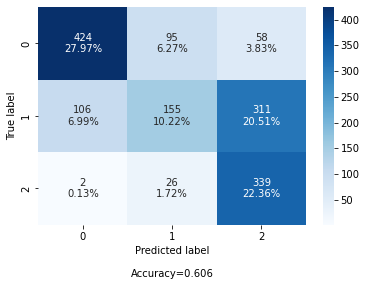

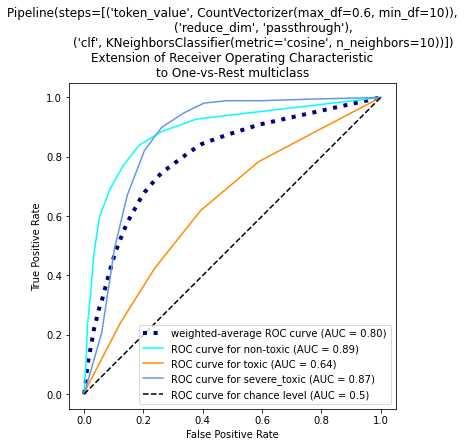

              precision    recall  f1-score   support

   non-toxic       0.80      0.73      0.76       577
       toxic       0.56      0.27      0.37       572
severe_toxic       0.48      0.92      0.63       367

    accuracy                           0.61      1516
   macro avg       0.61      0.64      0.59      1516
weighted avg       0.63      0.61      0.58      1516



In [93]:
analysis(subsets['balanced'], target_names, KNN_best, y_score1)

### Naive Bayes

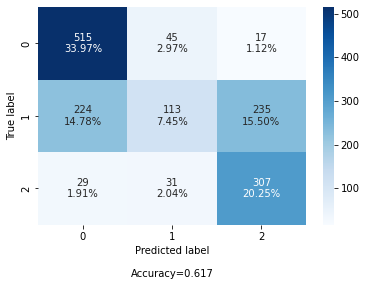

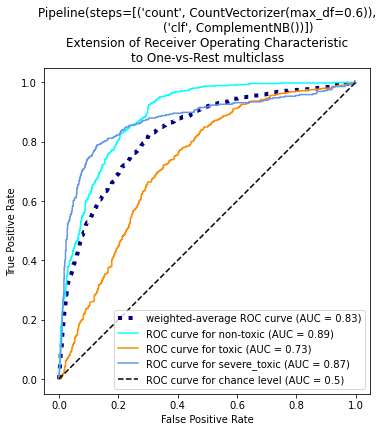

              precision    recall  f1-score   support

   non-toxic       0.67      0.89      0.77       577
       toxic       0.60      0.20      0.30       572
severe_toxic       0.55      0.84      0.66       367

    accuracy                           0.62      1516
   macro avg       0.61      0.64      0.58      1516
weighted avg       0.61      0.62      0.56      1516



In [75]:
analysis(subsets['balanced'], target_names, CV_NB_best, y_score1)

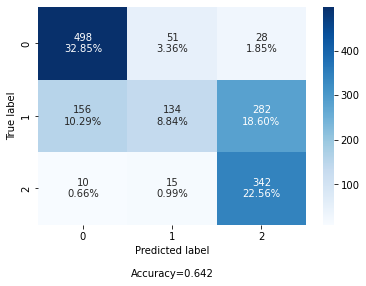

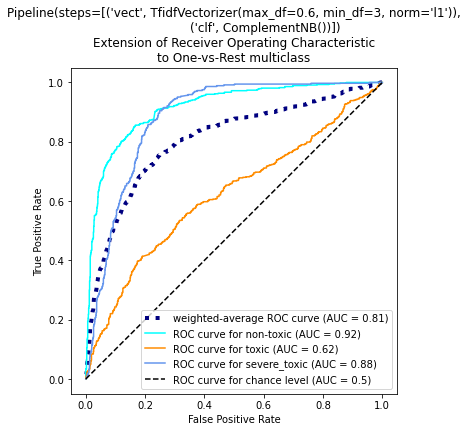

              precision    recall  f1-score   support

   non-toxic       0.75      0.86      0.80       577
       toxic       0.67      0.23      0.35       572
severe_toxic       0.52      0.93      0.67       367

    accuracy                           0.64      1516
   macro avg       0.65      0.68      0.61      1516
weighted avg       0.67      0.64      0.60      1516



In [76]:
analysis(subsets['balanced'], target_names, Tfidf_NB_best, y_score1)

### Model Evaluation Dataframe

In [87]:
score_df = pd.DataFrame(scores).set_index("Classifier/Pipeline")
score_df = score_df.round(2)
score_df

,Accuracy,ROC_AUC,Precision,Recall,F1
Classifier/Pipeline,,,,,
"(CountVectorizer(max_df=0.6, min_df=10), passthrough, KNeighborsClassifier(metric='cosine', n_neighbors=10))",0.61,0.80,0.63,0.61,0.58
"(CountVectorizer(max_df=0.6), ComplementNB())",0.62,0.83,0.61,0.62,0.56
"(TfidfVectorizer(max_df=0.6, min_df=3, norm='l1'), ComplementNB())",0.64,0.81,0.67,0.64,0.60
"(CountVectorizer(max_df=0.6, min_df=10), passthrough, KNeighborsClassifier(metric='cosine', n_neighbors=10))",0.61,0.80,0.63,0.61,0.58


### Top 3 Models with Unbalanced Dataset using Ensemble

In [88]:
estimators = {
    ('NaiveBayes', Tfidf_NB_best),
    ('KNN', KNN_best),
    ('Rocchio', Rocchio_best)
}

#create the ensemble classifier
ensemble = VotingClassifier(estimators, voting = 'hard')

#fit the model to the training data
ensemble.fit(subsets['unbalanced'][0], subsets['unbalanced'][1])

#test the model
ensemble.score(subsets['unbalanced'][2], subsets['unbalanced'][3])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


0.7025065963060686

In [89]:
analysis(subsets['unbalanced'], target_names, ensemble)

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


AttributeError: predict_proba is not available when voting='hard'